# Preparing enviroment

In [1]:
!rm *.h5

In [3]:
import warnings
warnings.filterwarnings('ignore')
!pip -q install opendatasets
!pip -q install pandas
!pip -q install darknet
!pip -q install numba

In [63]:
import opendatasets as od
import pandas

od.download(
    "https://mm.cs.uec.ac.jp/uecfoodpix/UECFOODPIXCOMPLETE.tar")

100%|██████████| 795238400/795238400 [02:38<00:00, 5009158.31it/s] 


In [64]:
! tar xf /kaggle/working/UECFOODPIXCOMPLETE.tar
! rm /kaggle/working/UECFOODPIXCOMPLETE.tar

# importes

In [4]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pydot
import darknet as dn
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
from tensorflow import keras
from keras import layers
from os import path


# Directories

In [5]:
DRIVE_FOLDER = "/kaggle/working/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE"
SUBSET_FOLDER = ""

TRAIN_IMAGE_DIR = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/train/img")
TRAIN_MASK_DIR = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/train/mask")

TEST_IMAGE_DIR = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/test/img")
TEST_MASK_DIR = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/test/mask")

# Settings

In [6]:
IMAGE_SIZE = 512
BATCH_SIZE = 4

CLASSES = 102

NUM_TRAIN_IMAGES = 6300
NUM_VAL_IMAGES = 2700

# Loading data

In [6]:
train_images = sorted(glob(str(TRAIN_IMAGE_DIR/'*.jpg')))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(str(TRAIN_MASK_DIR/'*.png')))[:NUM_TRAIN_IMAGES]

val_images = sorted(glob(str(TRAIN_IMAGE_DIR/'*.jpg')))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(str(TRAIN_MASK_DIR/'*.png')))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
print(train_images[0])
print(train_masks[0])
print(val_images[0])
print(val_masks[0])

/kaggle/working/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/img/1.jpg
/kaggle/working/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/1.png
/kaggle/working/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/img/5681.jpg
/kaggle/working/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask/5681.png


# Generating Dataset

In [10]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        red_channel = tf.expand_dims(image[:,:,0], axis=-1)
        red_channel.set_shape([None, None, 1])
        image = tf.image.resize(red_channel, [IMAGE_SIZE, IMAGE_SIZE], method='nearest')
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

In [11]:
def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

In [12]:
def data_generator(image_list, mask_list):
    with tf.device("CPU"):
      dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
      dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
      dataset = dataset.shuffle(buffer_size=100)
      dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [13]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.uint8)>
Val Dataset: <BatchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.uint8)>


# Visualization callback

In [16]:
# Visualization callback to see how mask prediction progresses.
class MaskCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        plot_mask_predictions(val_dataset,BATCH_SIZE)

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [15]:
# iou accuracy metric callback
class IOUCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        iou_metric = iou(val_dataset)
        print("iou: {}".format(iou_metric))

def iou(dataset):
    iou_metric = tf.keras.metrics.MeanIoU(num_classes=CLASSES)
    for image, mask in dataset:
        pred_mask = model.predict(image)
        pred_mask = create_mask(pred_mask)
        iou_metric.update_state(mask, pred_mask)
    return iou_metric.result().numpy()

In [13]:
def plot_mask_predictions(dataset, examples=3):
    plt.figure(figsize=(21, 7 * examples))

    for i, (image, mask) in enumerate(dataset.take(examples)):
        ax = plt.subplot(examples, 3, 3*i+1)
        plt.imshow(image[0].numpy().astype("uint8"))
        plt.axis("off")

        ax = plt.subplot(examples, 3, 3*i+2)
        plt.imshow(mask[0].numpy().astype("uint8").squeeze(axis=2), cmap='gray', vmin=0, vmax=tf.math.reduce_max(mask[0]))
        plt.axis("off")


        pred_mask = create_mask(model.predict(image))

        ax = plt.subplot(examples, 3, 3*i+3)
        plt.imshow(pred_mask.numpy().astype("uint8").squeeze(axis=2), cmap='gray', vmin=0, vmax=tf.math.reduce_max(pred_mask))
        plt.axis("off")

    plt.show()

# Model

In [17]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=CLASSES)
model.summary()

In [19]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

### Resuming Work model

In [20]:
if os.path.exists('/kaggle/working/cp.h5') :
    model =  keras.models.load_model('/kaggle/working/model.h5')
    model2 =  keras.models.load_model('/kaggle/working/model.h5')

## Model Training

In [20]:
EPOCHS = 25

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="cp.h5", 
    verbose=1, 
    save_weights_only=False , monitor='val_loss', save_best_only=True)

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,mode='auto')

In [ ]:
model_history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    validation_data=val_dataset, 
    callbacks=[MaskCallback(), cp_callback, early_callback]
)

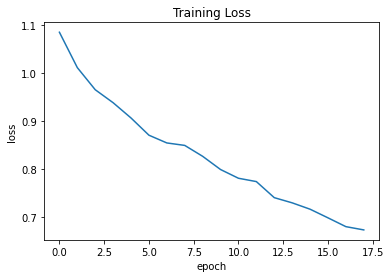

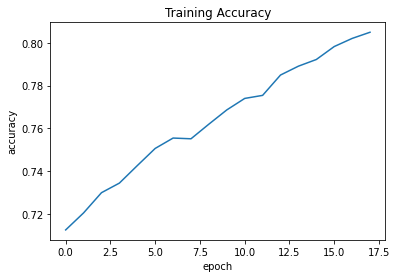

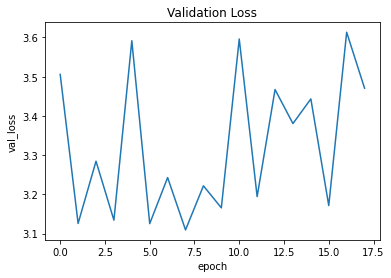

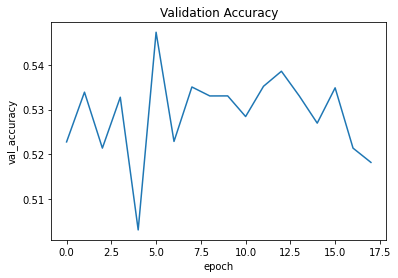

In [55]:
plt.plot(model_history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(model_history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(model_history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(model_history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.save('model.h5')

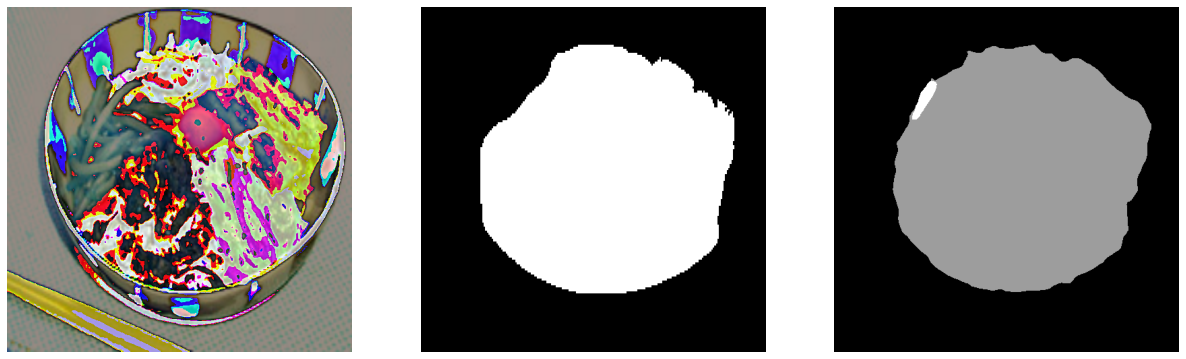

In [21]:
category_dict = read_category_file('/kaggle/working/UECFOODPIXCOMPLETE/data/category.txt')

test_dataset = data_generator(["/kaggle/working/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/test/img/1004.jpg"],["/kaggle/working/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/test/mask/1004.png"])

plot_mask_predictions(test_dataset, 1)

In [108]:
def plot_mask_predictions_for_test(dataset, examples , ms , im):
    plt.figure(figsize=(21, 7 * examples))
    plt.subplot(examples, 3, 1)
    plt.imshow(im)
    plt.axis("off")
    plt.title("Input Image")

    plt.subplot(examples, 3, 2)
    plt.imshow(ms)
    plt.axis("off")
    plt.title("Ground Truth Mask")

    for i, (image, mask) in enumerate(dataset.take(examples)):
        pred_mask = model.predict(image)
        pred_mask = np.argmax(pred_mask, axis=-1)
        pred_mask = pred_mask[..., np.newaxis]
        print(np.unique(pred_mask))
        pred_mask = colorize_mask(pred_mask, '/kaggle/working/UECFOODPIXCOMPLETE/data/category.txt')
        print(np.unique(pred_mask))
        ax = plt.subplot(examples, 3, 3*i+3)
        plt.imshow(pred_mask)
        plt.axis("off")

    plt.show()
    print(np.unique(pred_mask))
    print(np.unique(ms))
    
    

In [110]:
# Define a function to read the category file and return a dictionary mapping IDs to names
def read_category_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    category_dict = {}
    for line in lines[1:]:
        category_id, category_name = line.strip().split('\t')
        category_dict[int(category_id)] = category_name
    return category_dict

# Define a function to convert a predicted mask to a colorized mask using the category information
def colorize_mask(predicted_mask, category_file):
    category_dict = read_category_file(category_file)
    new_image = np.zeros((512,512) + (3,), dtype=np.uint8)
    # squeeze the predicted mask to remove the channel dimension
    pred = np.squeeze(predicted_mask)
    for id in category_dict.keys():
        for x,y in np.ndindex(pred.shape):
            if pred[x,y] == 0 :
                continue
            if pred[x,y] == id:
                new_image[x,y,0] = 16
    return new_image


[ 0 16 26]
[ 0 16]


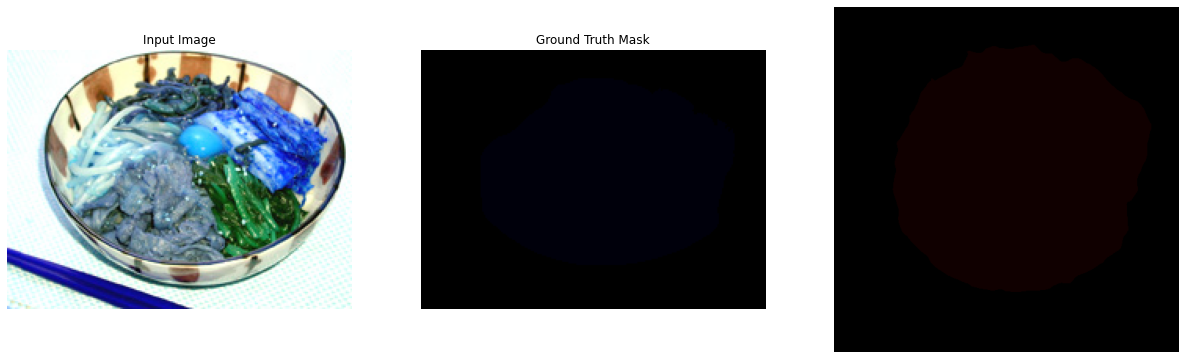

[ 0 16]
[ 0 11]


In [111]:
img = cv2.imread('/kaggle/working/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/test/img/1004.jpg')
mask = cv2.imread('/kaggle/working/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/test/mask/1004.png')

plot_mask_predictions_for_test(test_dataset, 1 , mask , img)